In [5]:
%load_ext autoreload
%autoreload 2


import sys
from pathlib import Path
import os

repo_root = Path(os.getcwd()).parent.resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import trigrad
import torch
import matplotlib.pyplot as plt
import time
from tests.testcases import *


torch.set_default_dtype(trigrad.precision)
torch.set_default_device("cuda")
print(trigrad.precision)

def imshow(im: torch.Tensor):
    im_np = im.detach().cpu().numpy().clip(0, 1)
    plt.imshow(im_np, extent=[-1, 1, -1, 1], origin="lower")

def cu_time(func, *args, **kwargs):
    torch.cuda.synchronize()
    start = time.perf_counter()
    result = func(*args, **kwargs)
    torch.cuda.synchronize()
    end = time.perf_counter()
    return result, end - start


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.float64


# Render

## Small Triangles

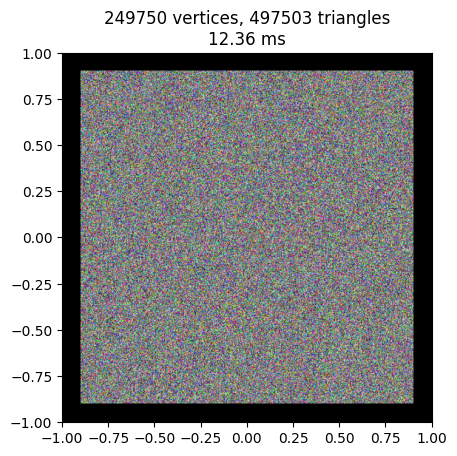

In [6]:
vertices, indices, colors = grid_mesh(500, 500, -0.9, 0.9, -0.9, 0.9)
opacities = torch.ones(vertices.shape[0])
im, t = cu_time(trigrad.render, vertices, indices, colors, opacities)
imshow(im)
plt.title(f"{vertices.shape[0]} vertices, {indices.shape[0]} triangles\n{t*1000:.2f} ms")
plt.show()

In [7]:
# 10.9ms without per pixel sort
# 11.6ms with per pixel sort
# 11.5ms with better pixel sort
%timeit trigrad.render(vertices, indices, colors, opacities); torch.cuda.synchronize()

12.1 ms ± 30.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Large Triangles

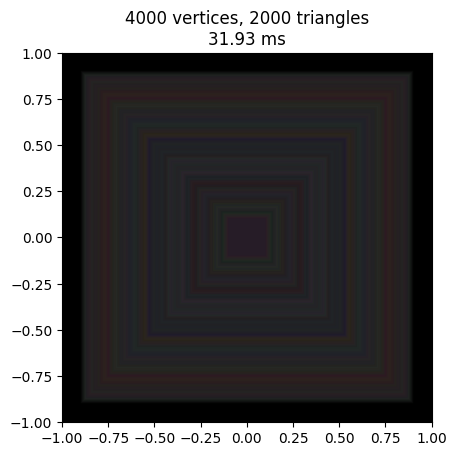

In [8]:
vertices, indices, colors = overlapping_squares(1000)
opacities = torch.ones(vertices.shape[0]) * 0.01

im, t = cu_time(trigrad.render, vertices, indices, colors, opacities, tile_width=16, tile_height=16)
imshow(im)
plt.title(f"{vertices.shape[0]} vertices, {indices.shape[0]} triangles\n{t*1000:.2f} ms")
plt.show()

In [9]:
%timeit trigrad.render(vertices, indices, colors, opacities); torch.cuda.synchronize()

32.3 ms ± 242 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Depth sorting test

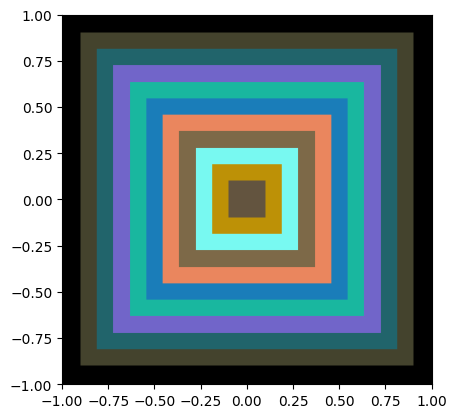

In [10]:
N = 10
vertices, indices, colors = overlapping_squares(N)
opacities = torch.ones(vertices.shape[0])
perm = torch.randperm(indices.shape[0])
indices = indices[perm]

im = trigrad.render(vertices, indices, colors, opacities)
imshow(im)
plt.show()

# Transparency

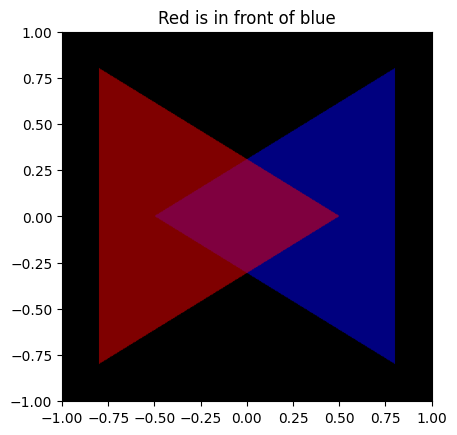

In [11]:
vertices, indices, colors = overlapping_triangles()
opacities = torch.full_like(vertices[:, 0], 0.5)
im = trigrad.render(vertices, indices, colors, opacities)
plt.title("Red is in front of blue")
imshow(im)
plt.show()

# Test early stopping

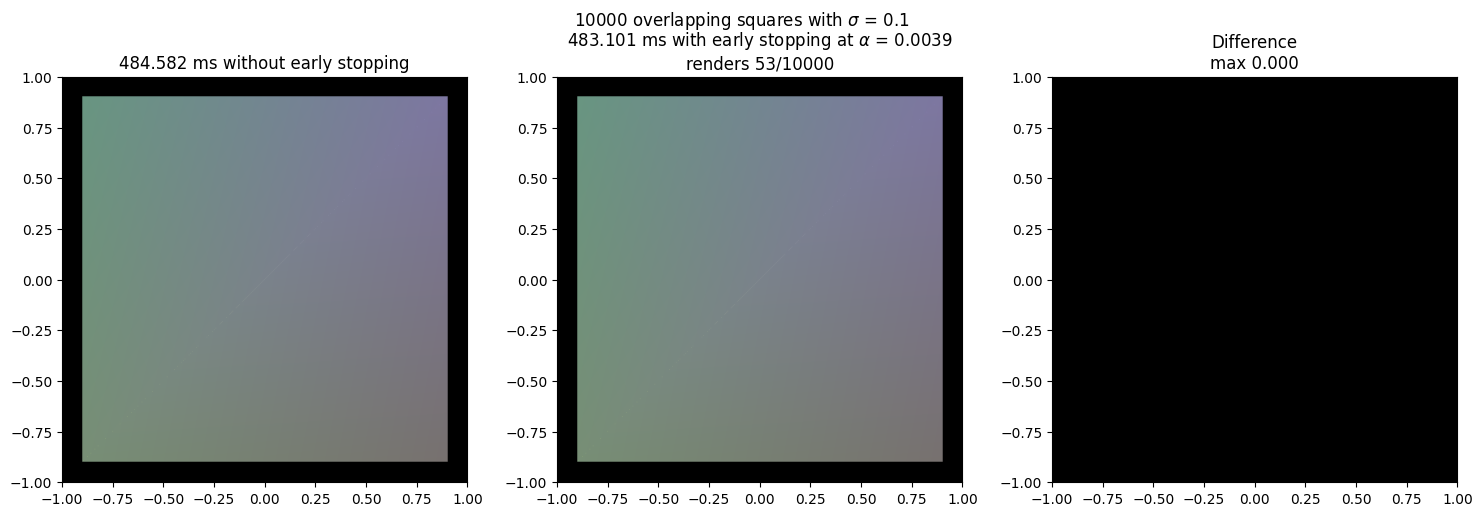

In [12]:
N = 10000
opacity = 0.1
th = 1 / 256
vertices = torch.zeros((N * 4, 4))
vertices[:, 3] = 1.0
vertices[::4, 0] = -0.9
vertices[::4, 1] = -0.9
vertices[1::4, 0] = 0.9
vertices[1::4, 1] = -0.9
vertices[2::4, 0] = 0.9
vertices[2::4, 1] = 0.9
vertices[3::4, 0] = -0.9
vertices[3::4, 1] = 0.9
indices = torch.zeros((N * 2, 3), dtype=torch.int32)
indices[::2, 0] = torch.arange(0, N * 4, 4)
indices[::2, 1] = torch.arange(1, N * 4, 4)
indices[::2, 2] = torch.arange(2, N * 4, 4)
indices[1::2, 0] = torch.arange(0, N * 4, 4)
indices[1::2, 1] = torch.arange(2, N * 4, 4)
indices[1::2, 2] = torch.arange(3, N * 4, 4)
vertices[indices[::2], 2] = torch.linspace(0, 1, N).unsqueeze(1)
vertices[indices[1::2], 2] = torch.linspace(0, 1, N).unsqueeze(1)
colors = torch.rand((N * 4, 3))
opacities = torch.full((N * 4,), opacity)


plt.figure(figsize=(15, 5))
plt.suptitle(f"{N} overlapping squares with $\\sigma$ = {opacity}")
plt.subplot(1, 3, 1)
im1, t1 = cu_time(trigrad.render, vertices, indices, colors, opacities, early_stopping_threshold=0)
torch.cuda.synchronize()
end = time.perf_counter()
plt.title(f"{(t1)*1000:.3f} ms without early stopping")
imshow(im1)
plt.subplot(1, 3, 2)
im2, t2 = cu_time(trigrad.render, vertices, indices, colors, opacities, early_stopping_threshold=th)
n_early = int(np.ceil((np.log(th) / np.log(1 - opacity))))
plt.title(f"{(t2)*1000:.3f} ms with early stopping at $\\alpha$ = {th:.4f}\nrenders {n_early}/{N}")
imshow(im2)
plt.subplot(1, 3, 3)
diff = im1 - im2
plt.title(f"Difference\nmax {diff.max():.3f}")
imshow(diff)

plt.tight_layout()
plt.show()

# Colors Backwards Test

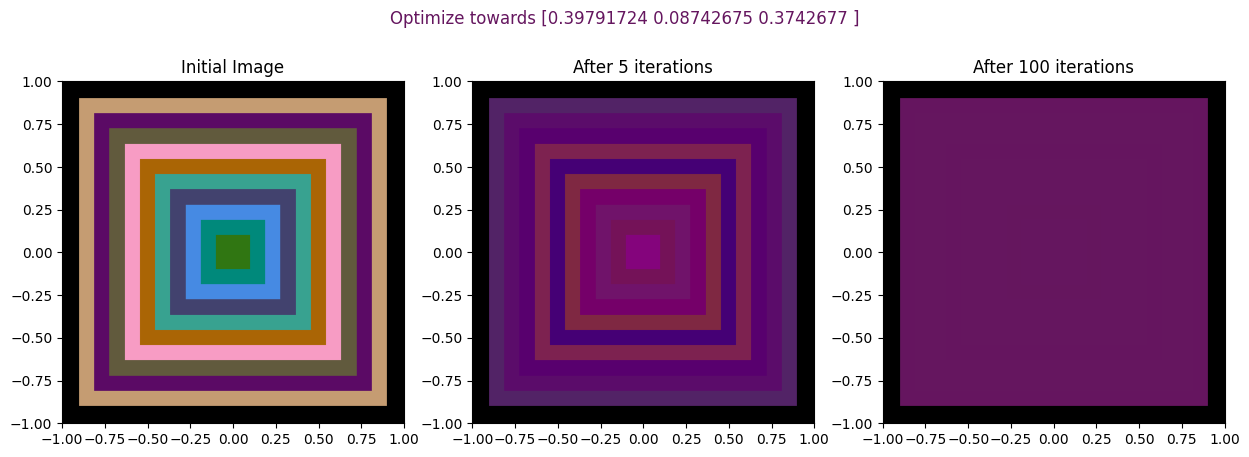

In [13]:
target_color = torch.rand((3,))
vertices, indices, colors = overlapping_squares(10)
opacities = torch.ones(vertices.shape[0])
im = trigrad.render(vertices, indices, colors, opacities)
colors.requires_grad_()
im = trigrad.render(vertices, indices, colors, opacities)
plt.figure(figsize=(15, 5))
plt.suptitle(f"Optimize towards {target_color.cpu().numpy()}", color=target_color.cpu().numpy())
plt.subplot(1, 3, 1)
plt.title("Initial Image")
imshow(im)
optim = torch.optim.Adam([colors], lr=0.1)
for i in range(5):
    optim.zero_grad()
    im = trigrad.render(vertices, indices, colors, opacities)
    loss = torch.mean((im - target_color) ** 2)
    loss.backward()
    optim.step()
with torch.no_grad():
    im = trigrad.render(vertices, indices, colors, opacities)
plt.subplot(1, 3, 2)
plt.title("After 5 iterations")
imshow(im)
for i in range(95):
    optim.zero_grad()
    im = trigrad.render(vertices, indices, colors, opacities)
    loss = torch.mean((im - target_color) ** 2)
    loss.backward()
    optim.step()
with torch.no_grad():
    im = trigrad.render(vertices, indices, colors, opacities)
plt.subplot(1, 3, 3)
plt.title("After 100 iterations")
imshow(im)
plt.show()

# Transparency Backwards Test

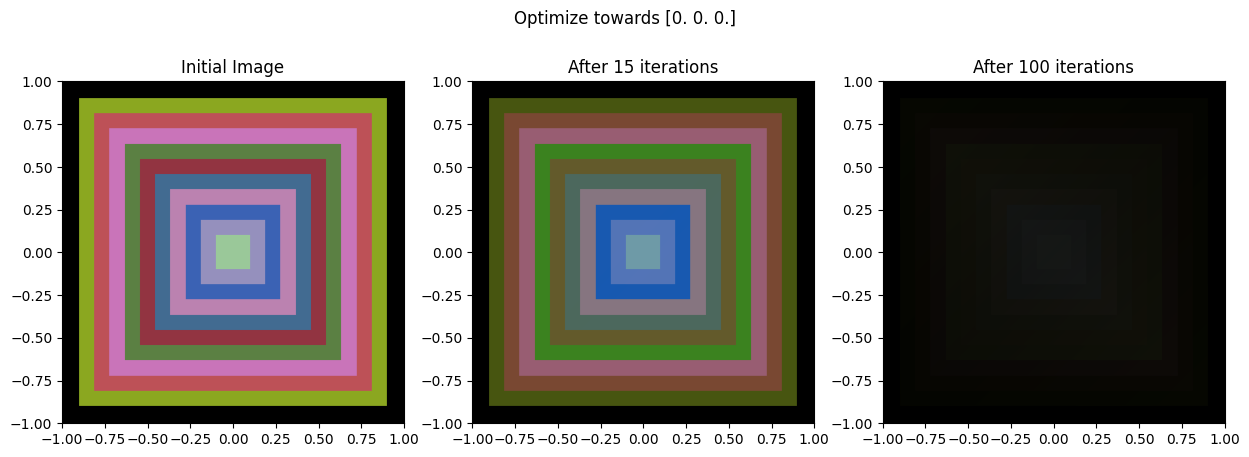

In [14]:
N = 10
target_color = torch.tensor([0.0, 0.0, 0.0])
vertices, indices, colors = overlapping_squares(10)
opacities = torch.ones(vertices.shape[0])
opacities.requires_grad_()
im = trigrad.render(vertices, indices, colors, torch.sigmoid(opacities))

plt.figure(figsize=(15, 5))
plt.suptitle(f"Optimize towards {target_color.cpu().numpy()}")
plt.subplot(1, 3, 1)
plt.title("Initial Image")
imshow(im)
optim = torch.optim.Adam([opacities], lr=0.1)
for i in range(15):
    optim.zero_grad()
    im = trigrad.render(vertices, indices, colors, torch.sigmoid(opacities))
    loss = torch.mean((im - target_color) ** 2)
    loss.backward()
    optim.step()
with torch.no_grad():
    im = trigrad.render(vertices, indices, colors, torch.sigmoid(opacities))
plt.subplot(1, 3, 2)
plt.title("After 15 iterations")
imshow(im)
for i in range(85):
    optim.zero_grad()
    im = trigrad.render(vertices, indices, colors, torch.sigmoid(opacities))
    loss = torch.mean((im - target_color) ** 2)
    loss.backward()
    optim.step()
with torch.no_grad():
    im = trigrad.render(vertices, indices, colors, torch.sigmoid(opacities))
plt.subplot(1, 3, 3)
plt.title("After 100 iterations")
imshow(im)
plt.show()

# Vertices Backwards Test

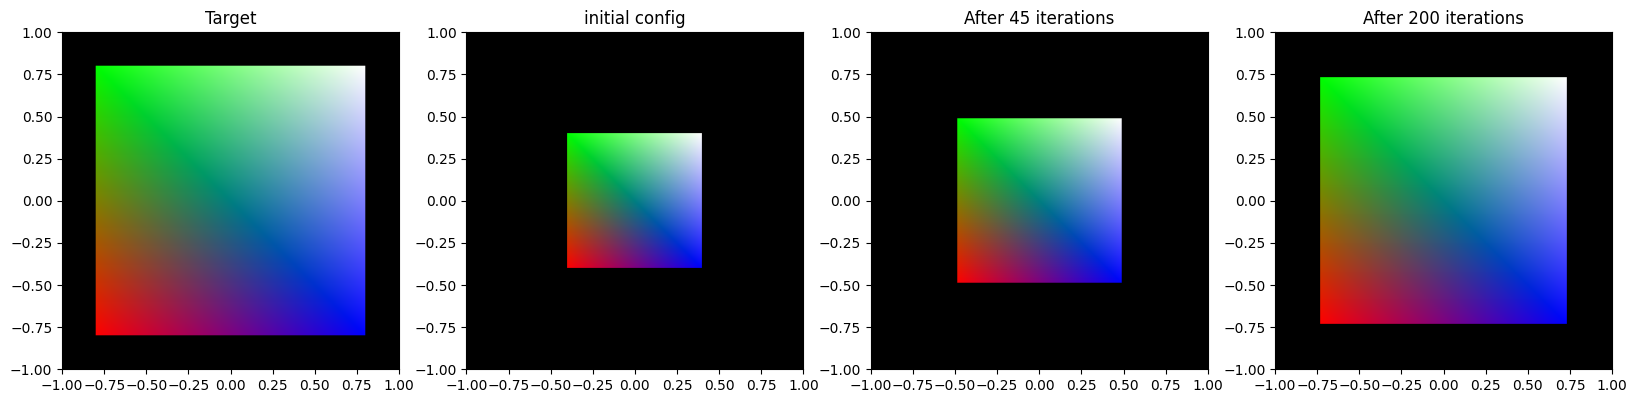

In [15]:
vertices, indices, colors = test_square()
opacities = torch.ones(vertices.shape[0])
im = trigrad.render(vertices, indices, colors, opacities)
target = im.detach().clip(0, 1.0)

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.title("Target")
imshow(target)
plt.subplot(1, 4, 2)
plt.title("initial config")
vertices[..., 0] = vertices[..., 0] / 2
vertices[..., 1] = vertices[..., 1] / 2
im = trigrad.render(vertices, indices, colors, opacities)
imshow(im)
plt.subplot(1, 4, 3)
plt.title("After 45 iterations")
vertices.requires_grad_()
optim = torch.optim.Adam([vertices], lr=0.002)
for i in range(45):
    optim.zero_grad()
    im = trigrad.render(vertices, indices, colors, opacities)
    loss = torch.mean((im - target) ** 2)
    loss.backward()
    vertices.grad[:, 3] = 0

    optim.step()
with torch.no_grad():
    im = trigrad.render(vertices, indices, colors, opacities)
imshow(im)
plt.subplot(1, 4, 4)
plt.title("After 200 iterations")
for i in range(155):
    optim.zero_grad()
    im = trigrad.render(vertices, indices, colors, opacities)
    loss = torch.mean((im - target) ** 2)
    loss.backward()
    vertices.grad[:, 3] = 0
    optim.step()
with torch.no_grad():
    im = trigrad.render(vertices, indices, colors, opacities)
imshow(im)
plt.show()

# Intersecting Triangles

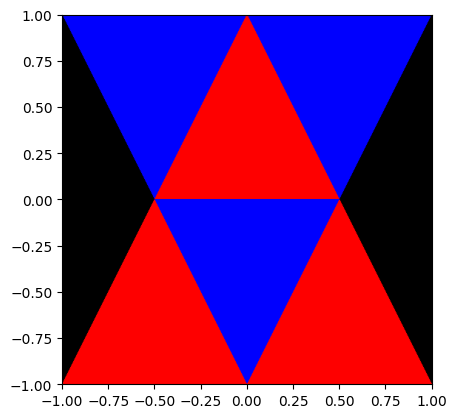

In [16]:
vertices, indices, colors, opacities = depth_overlap()
im = trigrad.render(vertices, indices, colors, opacities)
imshow(im)
plt.show()

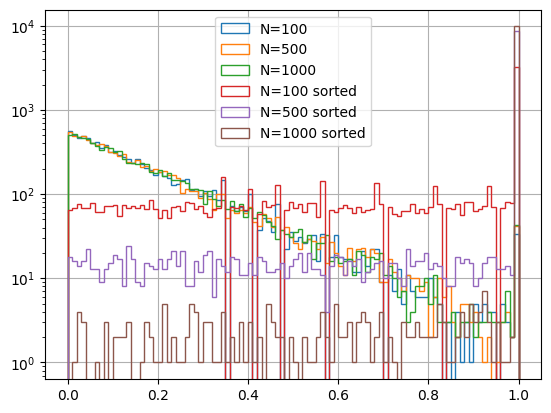

In [17]:
def count_skipped(N):
    ds = np.random.random(N)
    os = np.random.random(N)
    T = 1
    th = 1 / 256
    max_d = 0
    skipped = 0
    for d, o in zip(ds, os):
        if T <= th and d > max_d:
            skipped += 1
            continue
        T *= 1 - o
        if T > th and d > max_d:
            max_d = d
    return skipped


def count_skipped_sorted(N):
    ds = np.random.random(N)
    os = np.random.random(N)

    order = np.argsort(os)[::-1]
    ds = ds[order]
    os = os[order]
    T = 1
    th = 1 / 256
    max_d = 0
    skipped = 0
    for d, o in zip(ds, os):
        if T <= th and d > max_d:
            skipped += 1
            continue
        T *= 1 - o
        if T > th and d > max_d:
            max_d = d
    return skipped


for i in [100, 500, 1000]:
    skips = [count_skipped(i) / i for _ in range(10000)]
    plt.hist(skips, bins=100, histtype="step", label=f"N={i}", range=(0, 1))
for i in [100, 500, 1000]:
    skips = [count_skipped_sorted(i) / i for _ in range(10000)]
    plt.hist(skips, bins=100, histtype="step", label=f"N={i} sorted", range=(0, 1))
plt.grid()
plt.yscale("log")
plt.legend()